## Моделювання процесів Леві

In [177]:
import numpy as np
from scipy import integrate
np.random.seed(7008)

Змоделювати процес Леві з такими характеристиками $(\mu, \sigma^2, \nu(du)) = (0, 1, \nu(du))$, де $\nu(du) = (1 + \cos^2(u)/2)/|u|^{1+\alpha}du$

In [178]:
def v(u, alpha=0.5):
    return (1 + 0.5 * (np.cos(u)) ** 2) / (np.abs(u) ** (1 + alpha))

In [179]:
def integrate_cos(eps=0.01):
    return 2 * integrate.quad(v, eps, np.inf)[0]

def integrate_cos_mult_y(eps=0.01):
    pos_side = integrate.quad(lambda y: y * v(y), eps, 1)[0]
    neg_side = integrate.quad(lambda y: y * v(y), -1, -eps)[0]
    return pos_side + neg_side

Використаємо наступний алгоритм для моделювання траєкторій процесу:
1. Побудова рівномірної сітки на $[0,t]$: $t_k = k/n \cdot t$
2. Моделювання $Y_t = \mu_{\varepsilon} t + \sigma B_t$ на сітці; тут $\mu_{\varepsilon} = \mu - \int_{\varepsilon < |y| < 1} y\nu(dy)$
3. Моделюємо складений процес Пуассона $Z_t \sim CPP(\lambda_{\varepsilon})$, де $\lambda_{\varepsilon} = \int\limits_{|y| > \varepsilon}\nu(dy)$. Тобто
$Z_t = \sum_{j=1}^{N_t} \xi_j$, $N_t \sim PP(\lambda_{\varepsilon})$, $\xi_j \sim F(dy) = \nu(dy)/\lambda_{\varepsilon}1_{|y| > \varepsilon}$.
4. Остаточно $X_t^{(0,\varepsilon)} = Y_t + Z_t$

In [180]:
mu = 0
eps = 0.01
mu_eps = mu - integrate_cos_mult_y(eps)
mu_eps

0.0

В принципі цього можна було очікувати внаслідок парності ''щільності'' та непарності $f(y) = y$.

Змоделюємо $Y_t$ використовуючи прирости.

In [181]:
def generate_brownian(n, x0=0):
    m = 2 ** n
    delta = 1 / m
    increments = np.random.normal(loc=0, scale=np.sqrt(delta), size=m)
    trajectory = x0 + np.cumsum(np.append(0, increments))
    return trajectory

In [182]:
sigma = 1

m = 12
Wt = generate_brownian(m)

n = 2 ** m

t_max = 1
time_set = np.arange(0, n+1) * t_max / n

Yt = mu_eps * time_set + sigma * Wt

In [183]:
import matplotlib.pyplot as plt

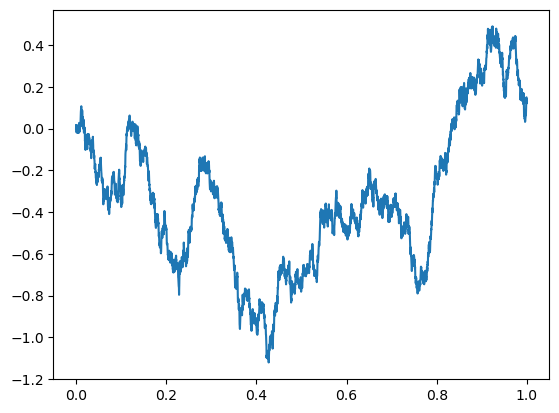

In [184]:
plt.plot(time_set, Y)
plt.show()

Змоделюємо $Z_t = CPP(\lambda_{\varepsilon})$

In [185]:
lambda_eps = integrate_cos(eps)
lambda_eps

/tmp/ipykernel_31759/3600983619.py:2: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return 2 * integrate.quad(v, eps, np.inf)[0]


58.21624893735164

In [186]:
# Генерування кількості доданків, Nt, за допомогою моментів зупинки
times_stop = []
t = 0
while t < t_max:
    t = float(t - np.log(np.random.uniform(size=1)) / lambda_eps)
    times_stop.append(t)

In [187]:
times_stop = np.array(times_stop)
times_stop = times_stop[:-1]
times_stop.shape

(72,)

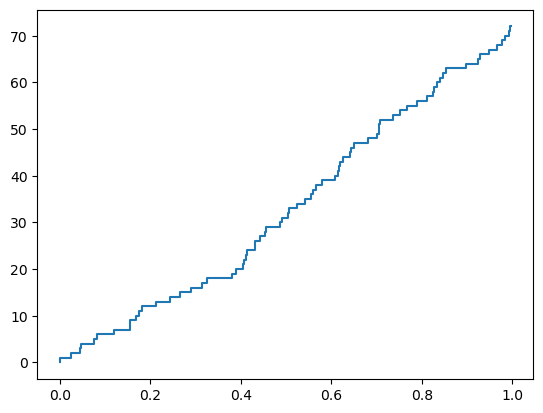

In [188]:
plt.step(
    np.append(0, times_stop),
    np.cumsum(np.append(0, np.ones(len(times_stop))))
)
plt.show()

In [189]:
def poisson_process(time_value):
    global times_stop
    jump_times = times_stop
    counts = 0
    for j in range(len(jump_times)):
        counts += 1 if (jump_times[j] <= time_value) else 0
    return counts

pp_vect = np.vectorize(poisson_process)

In [190]:
poisson_process(0.5)

30

In [191]:
pp_vect(0.5)
np.max(times_stop)

0.9973646825190503

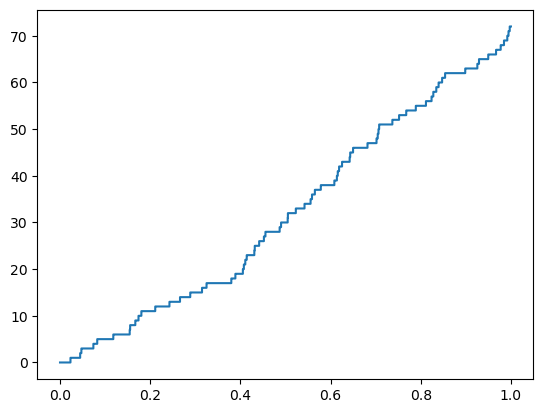

In [192]:
plt.step(
    time_set,
    pp_vect(time_set)
)
plt.show()

In [193]:
Nt = pp_vect(time_set)

$1\{|u| > \varepsilon\}(1 + \cos^2(u)/2)/|u|^{1+\alpha}\lambda_{\varepsilon}^{-1} \leq 1\{|u| > \varepsilon\}(1 + 1/2)/|u|^{1+\alpha} = 1\{|u| > \varepsilon\}\frac{1 + 1/2}{|u|^{1+\alpha}}\lambda_{\varepsilon}^{-1} = 3/2(C_{\alpha}\lambda_{\varepsilon})^{-1}g(u)$

$C_{\alpha}^{-1}2 = \int_{\varepsilon}^{+\infty} \frac{du}{u^{1+\alpha}} = \frac{1}{-\alpha u^{\alpha}}|_{\varepsilon}^{+\infty} = \frac{1}{\alpha \varepsilon^{\alpha}}$

In [194]:
C_alpha = 2 * 0.5 * eps ** 0.5
C_alpha

0.1

In [195]:
1 / (0.5 * eps ** 0.5)

20.0

$f(u) = (1 + \cos^2(u)/2)/|u|^{1+\alpha} 1\{|u| > \varepsilon\} \lambda_{\varepsilon}^{-1}$

$g(u) = 1 /|u|^{1+\alpha} 1\{|u| > \varepsilon\} C_{\alpha}$

In [196]:
K = 3/2 * C_alpha / lambda_eps
K

0.0025766002230995645

In [197]:
# Генерування доданків, на основі методу прийняття-відхилення
Nmax = np.max(Nt)
Nmax

72

In [198]:
def density_f(u):
    global lambda_eps, eps
    return (np.absolute(u) > eps) * v(u) / lambda_eps

def density_g(u):
    global C_alpha, eps
    return (np.absolute(u) > eps) * C_alpha / np.abs(u) ** (1 + 0.5)

$G(u) = \int_{-\infty}^x g(u)du = ...$.

$... = C_{\alpha}\frac{1}{\alpha (-x)^{\alpha}}$, $x \leq -\varepsilon$
$... = C_{\alpha}C_{\alpha}^{-1}/2 = 1/2$, $-\varepsilon < x \leq \varepsilon$
$... = 1/2 + C_{\alpha}\frac{1}{\alpha x^{\alpha}}$, $\varepsilon < x$

In [199]:
def G_inverse(p):
    alpha = 0.5
    global C_alpha
    if p <= 0.5:
        return - (C_alpha / (alpha * p)) ** (1 / alpha)
    else:
        return (C_alpha / (alpha * (p - 0.5))) ** (1 / alpha)

In [200]:
xi_k = []
while len(xi_k) < Nmax:
    u_gen_for_y_gen = float(np.random.uniform(size=1))
    y_gen = G_inverse(u_gen_for_y_gen)
    u_gen = float(np.random.uniform(size=1))
    if u_gen < density_f(y_gen) / (K * density_g(y_gen)):
        xi_k.append(y_gen)

In [201]:
xi_k

[0.55159185515172,
 -0.3325919170045589,
 -1.9071632245628405,
 -2.736348925743588,
 66.68056142105063,
 -1.4164761856053392,
 -0.16301146003037423,
 715.0371659966174,
 -0.7371421494890976,
 -0.23417969952451326,
 -30.21041945186956,
 -5.070636621817965,
 0.22492301932319342,
 1.4640481488279287,
 0.30762230822037134,
 44.43874573936693,
 304.2599643373487,
 -0.17456207694151468,
 -56.979129874454934,
 1.313506821654098,
 0.5854558228370816,
 0.20857155077162898,
 4.719985505719975,
 0.23438312872799932,
 0.17240812431693975,
 0.34495692283261004,
 -1.2685121104491293,
 0.5097691665299063,
 -0.2084264982339116,
 -0.8010469989058171,
 -0.3302346167701565,
 0.7073192675477552,
 -0.40104503069006686,
 1.4244740862661176,
 -0.40847551913109376,
 1.2210052992309819,
 -1.7125579189061644,
 -12.98953363515326,
 1.0757110581801261,
 0.1863061363345288,
 -5.471348997923929,
 2.063151226328258,
 0.18596287156255414,
 0.17450327600144008,
 1.1705251264264391,
 0.18029705356861536,
 -437.58325831

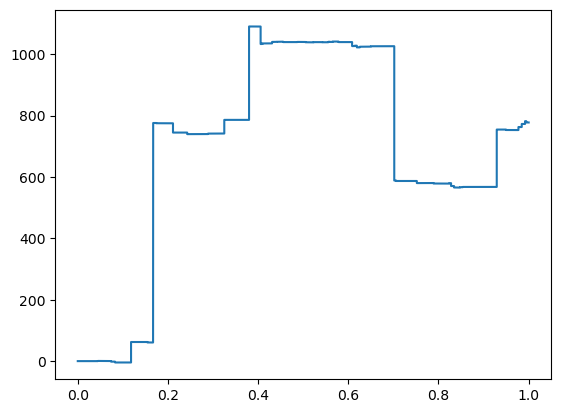

In [202]:
Zt = []
for nn in Nt:
    k = nn - 1 if nn > 1 else 0
    Zt.append(np.sum(xi_k[0:k]))
plt.step(time_set, Zt)
plt.show()

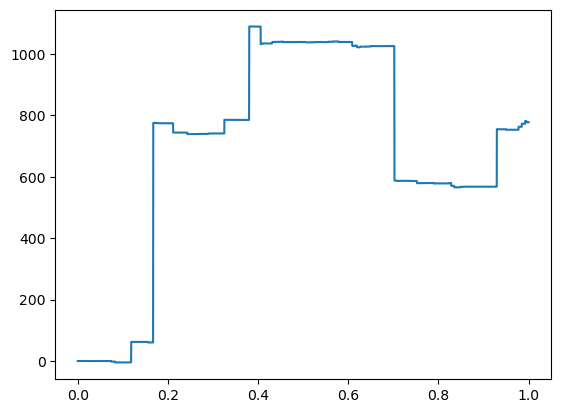

In [203]:
Xt = Yt + Zt
plt.plot(time_set, Xt)
plt.show()